# Previsão de Receita (pagamento das apólices)

## Tratamento de dados e EDA

In [84]:

#Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


In [85]:
# Coletando os dados 
df_venda = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='venda')
df_receita = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='receita')

In [86]:
df_receita

,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,65.300
1,2019,1,72,57,4,1360.235
2,2019,1,72,56,3,276.490
3,2019,1,72,47,2,-1707.095
4,2019,1,72,38,3,1080.745
...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935
1076,2020,6,72,13,3,3244.695
1077,2020,6,72,12,3,267.235
1078,2020,6,72,9,12,2157.955


In [87]:
df_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ano           1080 non-null   int64  
 1   mes           1080 non-null   int64  
 2   seguradora    1080 non-null   int64  
 3   vendedor      1080 non-null   int64  
 4   tot_apolices  1080 non-null   int64  
 5   receita       1080 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 50.8 KB


### Verificando a distribuição da coluna receita

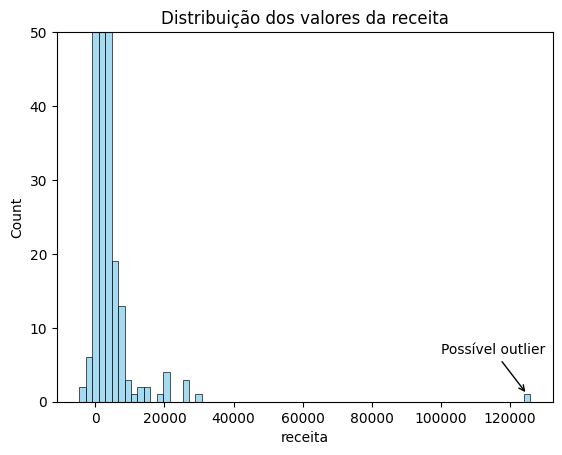

In [88]:
sns.histplot(df_receita.receita, bins=70, kde=False, color='skyblue')
#Limite o y para 50 pois não estava dando para ver as frequências dos outros valores
plt.ylim(0, 50)
plt.title('Distribuição dos valores da receita')

comentario = "Possível outlier"  
plt.annotate(comentario, xy=(125000, 1), xytext=(100000, 6.5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.show()

Como pode ser visto há um possível outlier acima de 120.000 de receita

In [89]:
#Investigando esse possível outlier
df_receita_outlier = df_receita.loc[df_receita.receita > 120000].copy()

#Verificando na tabela de vendas

df_venda_outlier = df_venda.loc[df_venda.venda > 120000].copy()

print(df_receita_outlier)
print(df_venda_outlier)


      ano  mes  seguradora  vendedor  tot_apolices     receita
651  2019   12          55        16             1  125950.595
      ano  mes  seguradora  vendedor  tot_apolices       venda
777  2019   12          55        16             1  125950.595
867  2020    1          31        35             6  148598.290


Como pode ser ver, o possível outlier também está presente na tabela de vendas.

In [104]:
#Removendo valores negativos pois são cancelamentos
df_receita = df_receita.query('receita >= 0')

#Adicionando uma coluna de datetime para o modelo

df_receita['data'] = df_receita.ano.astype(str) + '-' + df_receita.mes.astype(str)
df_receita['data'] = pd.to_datetime(df_receita.data)

df_receita

,ano,mes,seguradora,vendedor,tot_apolices,receita,data
0,2019,1,72,58,1,65.300,2019-01-01
1,2019,1,72,57,4,1360.235,2019-01-01
2,2019,1,72,56,3,276.490,2019-01-01
4,2019,1,72,38,3,1080.745,2019-01-01
5,2019,1,72,35,2,446.095,2019-01-01
...,...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935,2020-06-01
1076,2020,6,72,13,3,3244.695,2020-06-01
1077,2020,6,72,12,3,267.235,2020-06-01
1078,2020,6,72,9,12,2157.955,2020-06-01


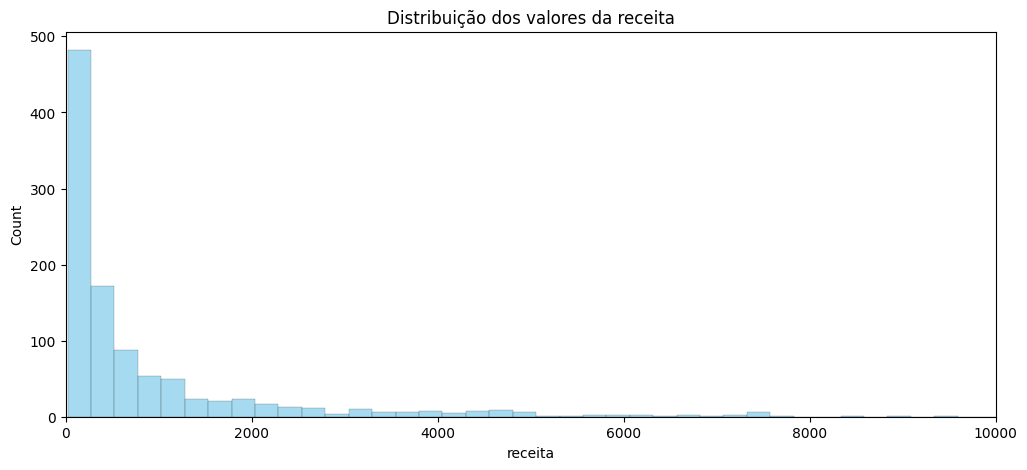

In [91]:
#Verificando a distribuição após remover os valores cancelados
plt.figure(figsize=(12, 5))
sns.histplot(df_receita.receita, bins=500, kde=False, color='skyblue')
#limitei o x para não aparecer o possível outlier
plt.xlim(0,10000)
plt.title('Distribuição dos valores da receita')
plt.show()

A distribuição dos valores da receita são similares a uma distribuição exponencial

## Criação do Modelo

### modelo Decision Tree Regressor

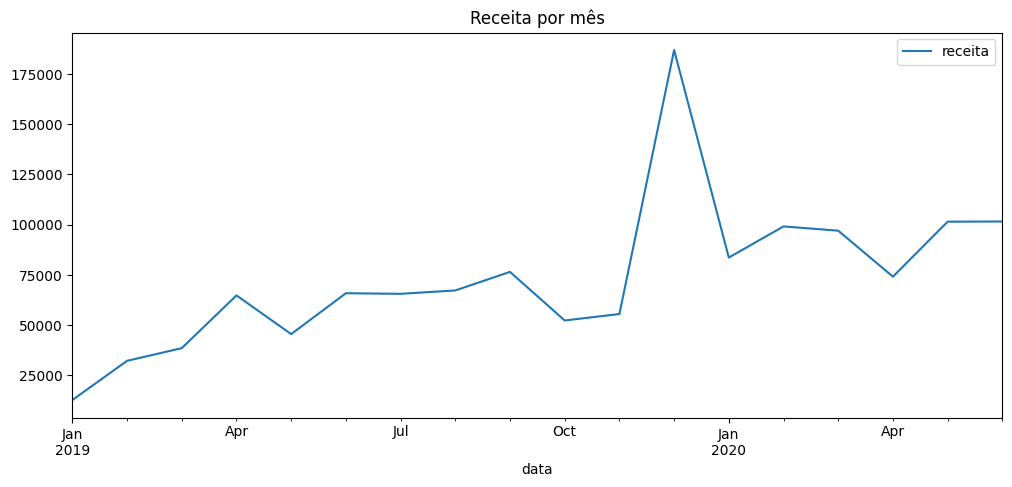

In [92]:
#Tratamento para o modelo


df_receita_modelo = df_receita.groupby(['data', 'ano', 'mes'])['receita'].sum().copy().reset_index()

df_receita_modelo.plot(x='data', y='receita' ,figsize=(12, 5))
plt.title('Receita por mês')
plt.show()

O nosso possível outlier afetando os valores de dezembro de 2019 causando o pico

In [93]:
# Dividindo entre Treino e Teste

treino_df = df_receita_modelo[df_receita_modelo.data < '2020-04-01']
teste_df = df_receita_modelo[df_receita_modelo.data >= '2020-04-01']

features = ['ano', 'mes']

x_treino = treino_df[features]
y_treino = treino_df['receita']

x_teste = teste_df[features]
y_teste = teste_df['receita']


In [94]:
tree_model = DecisionTreeRegressor()
tree_model.fit(x_treino, y_treino)

DecisionTreeRegressor()

Mean Squared Error: 188915075.72501662
Mean absolute percentage Error: 13.298862700531897


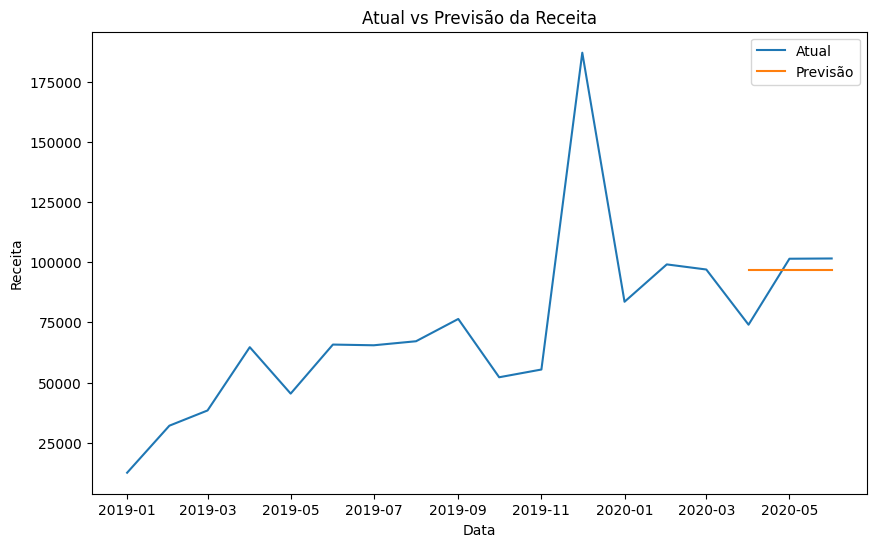

In [95]:
previsoes = tree_model.predict(x_teste)

# Avaliando a performance  do modelo
mse = mean_squared_error(y_teste, previsoes)
mape = mean_absolute_percentage_error(y_teste, previsoes)

print(f"Mean Squared Error: {mse}")
print(f"Mean absolute percentage Error: {mape * 100}")

# Visualizando a previsão com o atual

plt.figure(figsize=(10, 6))
plt.plot(df_receita_modelo['data'], df_receita_modelo.receita, label='Atual')
plt.plot(teste_df['data'], previsoes, label='Previsão')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.title('Atual vs Previsão da Receita')
plt.legend()
plt.show()

### Ridge Regression

In [96]:
ridge_model = Ridge()
ridge_model.fit(x_treino, y_treino)

Ridge()

Mean Squared Error: 124319084.15917619
Mean absolute percentage Error: 10.587683635400692


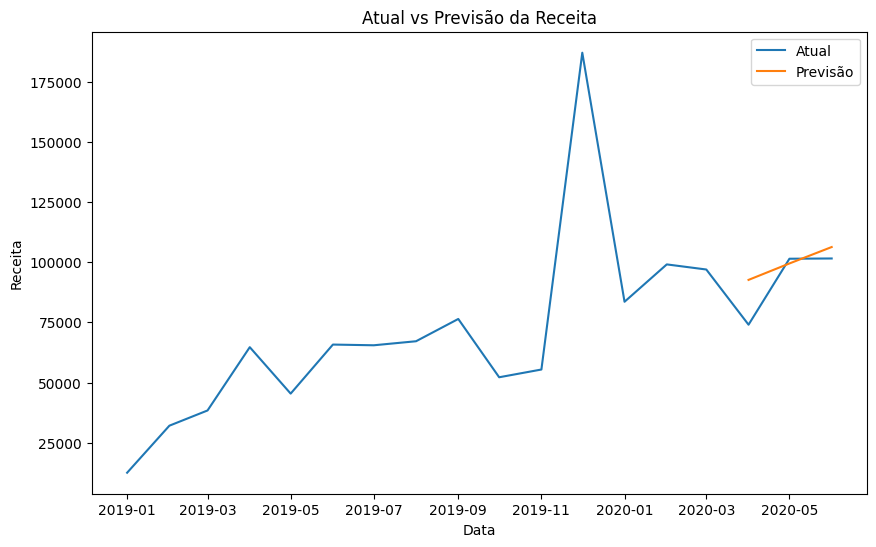

In [97]:
previsoes = ridge_model.predict(x_teste)

# Avaliando a performance  do modelo
mse = mean_squared_error(y_teste, previsoes)
mape = mean_absolute_percentage_error(y_teste, previsoes)

print(f"Mean Squared Error: {mse}")
print(f"Mean absolute percentage Error: {mape * 100}")

# Visualizando a previsão com o atual

plt.figure(figsize=(10, 6))
plt.plot(df_receita_modelo['data'], df_receita_modelo.receita, label='Atual')
plt.plot(teste_df['data'], previsoes, label='Previsão')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.title('Atual vs Previsão da Receita')
plt.legend()
plt.show()

### Prevendo datas futuras

In [103]:
#Colocando as datas até o final do ano de 2020

datas_futuras = pd.date_range(start=df_receita_modelo['data'].max(), end='2020-12-31', freq='MS')

#Adicionando as colunas de ano e mês para o modelo
datas_futuras_df = pd.DataFrame({'data': datas_futuras})
datas_futuras_df['ano'] = datas_futuras_df['data'].dt.year
datas_futuras_df['mes'] = datas_futuras_df['data'].dt.month


In [102]:
previsoes_futuras = ridge_model.predict(datas_futuras_df[['ano', 'mes']])

previsoes_futuras_df = pd.concat([datas_futuras_df, pd.DataFrame({'receita' : previsoes_futuras})], axis = 1)

previsoes_futuras_df

,data,ano,mes,receita
0,2020-06-01,2020,6,106296.527584
1,2020-07-01,2020,7,113121.718696
2,2020-08-01,2020,8,119946.909808
3,2020-09-01,2020,9,126772.100920
4,2020-10-01,2020,10,133597.292032
5,2020-11-01,2020,11,140422.483144
6,2020-12-01,2020,12,147247.674256


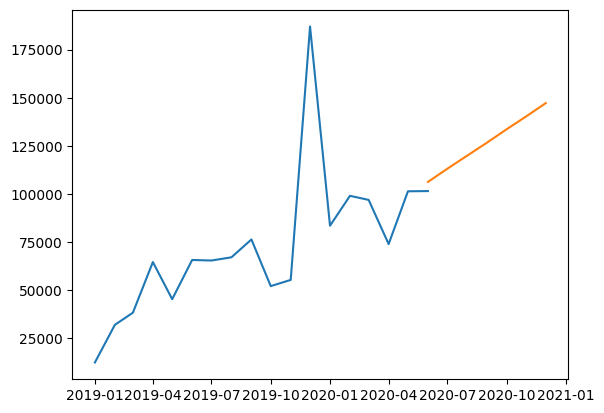

In [ ]:
#Plottando as previsões e as receitas anteriores
plt.plot(df_receita_modelo['data'], df_receita_modelo['receita'])
plt.plot(datas_futuras_df['data'], previsoes_futuras)
plt.show()

## Conclusão